## Glued Trees Annotated Tutorial Notebook
This notebook is meant to be a guide explaining the code of the glued trees algorithm in Classiq, including the creation and preparation of the Pauli list from the Hamiltonian modeling the system of oscillators representing the columns of the glued trees structure and the creation and execution of the corresponding quantum circuit. To read more about the problem, process, and theory behind the code, check out the README file attached to the repository.

The notebook is used in conjunction with the `pauli_cache.json` file which saves the dictionary of generated Pauli lists as a JSON file. The `generate_pauli_list.py` and `approximate_pauli_list.py` files are used to populate the cache.

In [1]:
from typing import cast
from functools import wraps
from classiq import *
from classiq.execution import ExecutionPreferences
from qiskit.quantum_info import SparsePauliOp
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import json
import os
%config InlineBackend.figure_format = 'retina' # improve graph image quality

The following code segments contain all of the helper methods that relate to creating the matrix $-\sqrt{\mathbf{A}}$ where
$$
\mathbf{A} = \begin{bmatrix}
3 & -\sqrt{2} & 0 & 0 & 0 & 0 & \cdots & 0 \\
-\sqrt{2} & 3 & -\sqrt{2} & 0 & 0 & 0 & \cdots & \vdots\\
\vdots & \ddots & \ddots & \ddots & 0 & 0 & \cdots & \vdots \\
0 & \cdots & -\sqrt{2} & 3 & -2 & \cdots & 0 & 0 \\
0 & 0 & \cdots & -2 & 3 & -\sqrt{2} & \cdots & 0 \\
\vdots & \cdots & 0 & 0 & \ddots & \ddots & \ddots & \vdots \\
\vdots & \cdots & 0 & 0 & 0 & -\sqrt{2} & 3 & -\sqrt{2} \\
0 & \cdots & 0 & 0 & 0 & 0 & -\sqrt{2} & 3
\end{bmatrix}
$$
and processing it in a form that Classiq's `exponentiation_with_depth_constraint` function can understand.

The `pauli_str_to_enums` and `pauli_list_to_hamiltonian` functions are taken from the Classiq documentation and convert the list of tuples input into a `PauliTerm` list, the input Classiq recognizes for its exponentiation function.

In [2]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

All Pauli list outputs are cropped so they have no more than 200 terms. This is to ensure that the circuit depth is at a reasonable range (low thousands) given the limits of current quantum hardware. As a result of this approach, as the number of qubits increases, the accuracy of the Pauli list in comparison to the matrix it represents diminishes so the circuit depth remains roughly constant.

Pauli lists for qubit values small enough to calculate (13 qubits and lower) are generated and cropped in the `generate_pauli_list.py` Python script, which uses an ad hoc formula described in the repository README file to pick the 200 ostensibly most representative Pauli strings in the full Pauli list. The Pauli lists for qubit values too large to fully calculate (greater than 13 qubits) are approximated in the `approximate_pauli_list.py` Python script, where the Pauli terms are padded with the first character of the previous largest Pauli list in the cache, filling the length needed for the given qubit value.

The `pauli_cache.json` file in its current form is a dictionary taking in an integer value and returning a Pauli list value. It currently contains the generated Pauli lists from 1-13 qubits and approximated Pauli lists for 15, 20, 25, and 30 qubits. The `pauli_str` function returns the cached Pauli list for the input qubit size `dim`.

In [15]:
def pauli_str(dim):
    cache = json.load(open('pauli_cache.json', 'r'))
    if str(dim) not in cache:
        raise KeyError("Input qubit size not in cache")
    return cache[str(dim)]

As a preliminary test, we begin by using the `n_oscillators` function to simulate our Hamiltonian represented by Pauli strings of length `dim` from $t=0$ to $t=$`maxim` in `step` intervals. The `add_point` inner function is called repeatedly to simulate exponentiation using Classiq's Aer simulator for different time values. The output is a plot of the shots of the state representing the exit column oscillator $\ket{2^q-1}$ where $q$ is the number of qubits, `dim`.

Since the Pauli strings will be of length $q$, the matrix $\mathbf{A}$ must be of size $2^q \times 2^q$. Since we know that $\mathbf{A}$ is also of size $2n \times 2n$, the relationship $n=2^{q-1}$ is formed. This means that the state representing the exit column oscillator can also be thought of as $\ket{2n-1}$.

In [4]:
def n_oscillators(dim, maxim, step):
    pauli_list = pauli_str(dim)
    def add_point(t):
        @qfunc
        def main(state: Output[QArray[QBit]]) -> None:
            allocate(len(pauli_list[0][0]), state)
            exponentiation_with_depth_constraint(
                pauli_operator=pauli_list_to_hamiltonian(pauli_list),
                evolution_coefficient=t,
                max_depth=2000,
                qbv=state,
            )
        execution_preferences = ExecutionPreferences(num_shots=4096)
        model = set_execution_preferences(create_model(main), execution_preferences)
        quantum_program = synthesize(model)
        job = execute(quantum_program)
        results = job.result()
        return results[0].value
    times = np.arange(0, maxim, step)
    output = []
    for t in times:
        point = add_point(t)
        try:
            index = [idx for idx, s in enumerate(point.parsed_counts) if str(2**dim-1)+'.0' in str(s)][0]
            output.append(point.parsed_counts[index].shots/point.num_shots)
        except IndexError:
            output.append(0)
    plt.plot(times, output)
    plt.xlabel("Time (s)")
    plt.ylabel("Proportion of |"+str(2**dim-1)+"> shots")
    plt.show()

This is an example of the `n_oscillators` function, simulating the proportion of $\ket{7}$ shots for 3 qubits ($n=4$) from $t=0$ to $t=16$ in 1 second intervals. The important thing to note is that there is a spike at $t \approx 2n=8$. A spike should be expected for all states laggingly, starting with $\ket{0}$ at $t \approx 0$, as the initial push of the first ball in the system of balls and springs propagates throughout the system until it reaches the last ball.

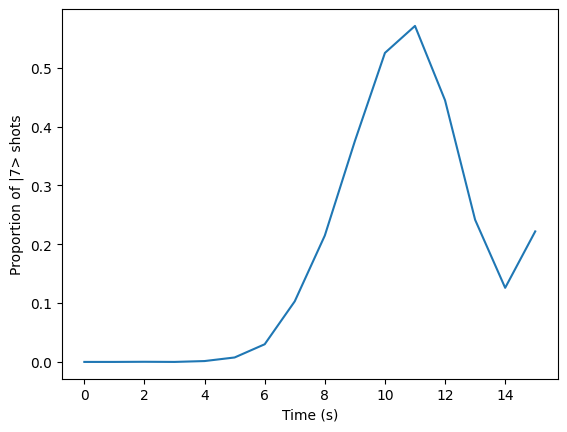

In [43]:
n_oscillators(3, 16, 1)

This is an example of the function, this time simulating the proportion of $\ket{15}$ shots for 4 qubits ($n=8$) from $t=0$ to $t=24$ in 1 second intervals. Once again, as expected, there is a spike at $t \approx 2n=16$.

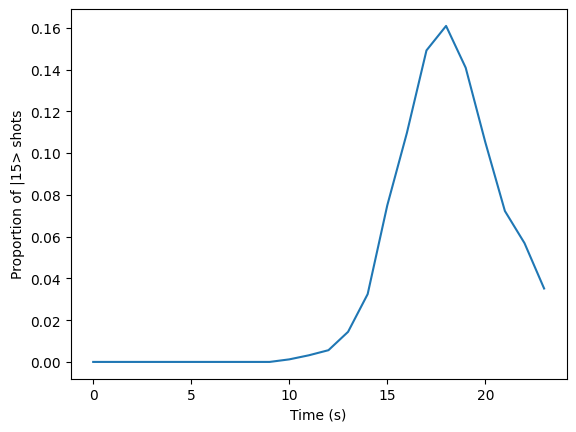

In [44]:
n_oscillators(4, 24, 1)

We are now ready to run our main function, `run_point`. This function takes in the number of qubits `dim` and the time `t` to perform Hamiltonian simulation $\exp(-iHt)$ where $H=-\sqrt{\mathbf{A}}$ using the `exponentiation_with_depth_constraint` function in the Classiq software development kit. 

The `max_depth` parameter is set to 1300, which is around the range of the current limit for comprehensible results in state of the art trapped ion quantum computers. The `num_shots` parameter is set to 8192 to give enough of room for significant spikes in a state to be apparent given the high number of total possible states.

We will run the `run_point` function through a helper function `run_range`, which executes it 9 times in total for a given qubit size, spanning from $t=2n-40$ to $t=2n+40$ in 10 second intervals. This range gives time to observe oscillation occurring at high state values while also being close enough around $t=2n$, the time where we are expecting some spike in high states.

In [18]:
def run_point(dim, t):
    pauli_list = pauli_str(dim)
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=1300,
            qbv=state,
        )
    execution_preferences = ExecutionPreferences(num_shots=8192)
    model = set_execution_preferences(create_model(main), execution_preferences)
    quantum_program = synthesize(model)
    job = execute(quantum_program)
    filename = 'results/'+str(dim)+'-qubits-simulator/2n'+(str(t-2**dim) if t < 2**dim else '+'+str(t-2**dim))+'.json'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    json.dump(dict(job.result()[0].value), open(filename, 'w'))

def run_range(dim):
    for i in range(-40, 50, 10):
        run_point(dim, 2**dim+i)

The following code segment displays the execution of `run_range` for 10 qubits ($n=512$), a higher qubit value that is still simulatable. In addition, it is low enough that its Pauli list can still be fully generated and cropped.

In [39]:
run_range(10)

The following code segment, on the other hand, displays the execution of `run_range` for 20 qubits ($n=524288$), a qubit value that is still simulatable but where its Pauli list cannot be generated. The Pauli list for 20 qubits is approximated from the largest value that can be generated in reasonable time, 13 qubits, using the `approximate_pauli_list.py` script. 

In [45]:
run_range(20)

We can now graph the results we have generated using the simulator, which have been saved into directories in the `results` folder based on their qubit size. The `graph_results` function creates a stackplot of the proportion of shots for the 8 highest possible bitstrings for a given qubit value from $t=2n-40$ to $t=2n+40$ and saves it in the `graphs` folder. As a reminder, the expected behavior is a spike for most of these values at $t \approx 2n$.

In [29]:
def graph_results(dim, sim=False):
    states = ['-40', '-30', '-20', '-10', '+0', '+10', '+20', '+30', '+40']
    times = [2**dim+int(i) for i in states]
    data = {}
    for i in states:
        with open('results/'+str(dim)+'-qubits'+('-simulator' if sim else '')+'/2n'+i+'.json', 'r') as f:
            j = json.load(f)
            counts = dict([i for i in j['counts'].items() if i[0][:-3] == '1'*(dim-3)])
            for k in range(8):
                key = '1'*(dim-3)+bin(k)[2:].rjust(3, '0')
                if key not in data:
                    data[key] = []
                data[key].append(counts[key]/j['num_shots'] if key in counts else 0)
    plt.stackplot(times, np.array(list(data.values())), labels=['1...1'+i[-3:] for i in data.keys()])
    plt.legend(loc='upper left')
    plt.xlabel('Time (s)')
    plt.ylabel('Proportion of Shots')
    plt.title(r'Glued Trees System at $t \approx 2n$ for '+str(dim)+' Qubits'+(' (Simulator)' if sim else ''))
    plt.savefig('graphs/'+str(dim)+'_qubits_simulator.png', bbox_inches='tight', dpi=300)
    plt.show()

The following code segment displays the graph for 10 qubits, a qubit size with a generated and cropped Pauli list. As expected, there is a large spike in the highest bitstrings at $t \approx 2n$, in this case slightly later.

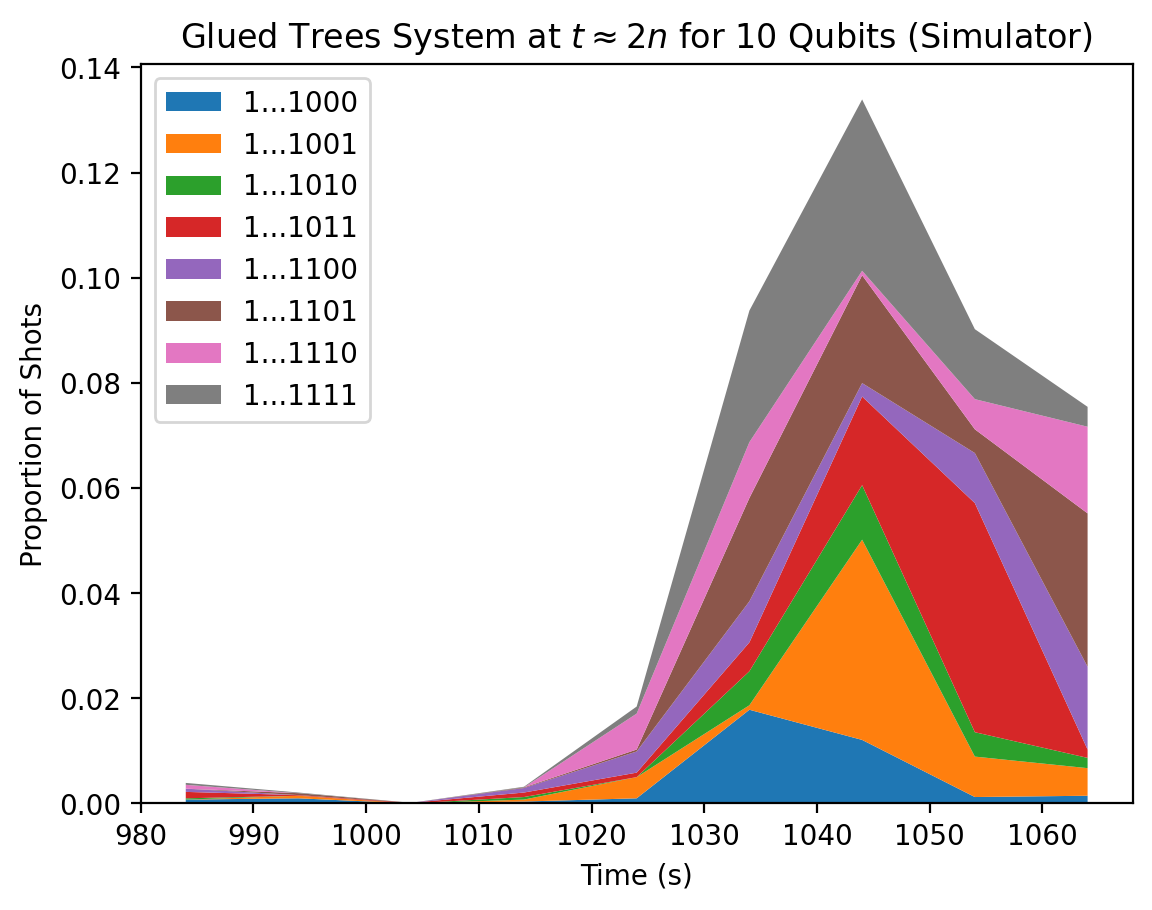

In [30]:
graph_results(10, sim=True)

The following code segment displays the graph for 20 qubits, a qubit size with an approximated Pauli list. The spike here happens to be almost exactly at $t=2n$, and the proportion of shots for these values is very high, likely meaning that the approximated list of Pauli strings for this qubit size happened to imbue a lot of information corresponding to the highest possible bitstrings.

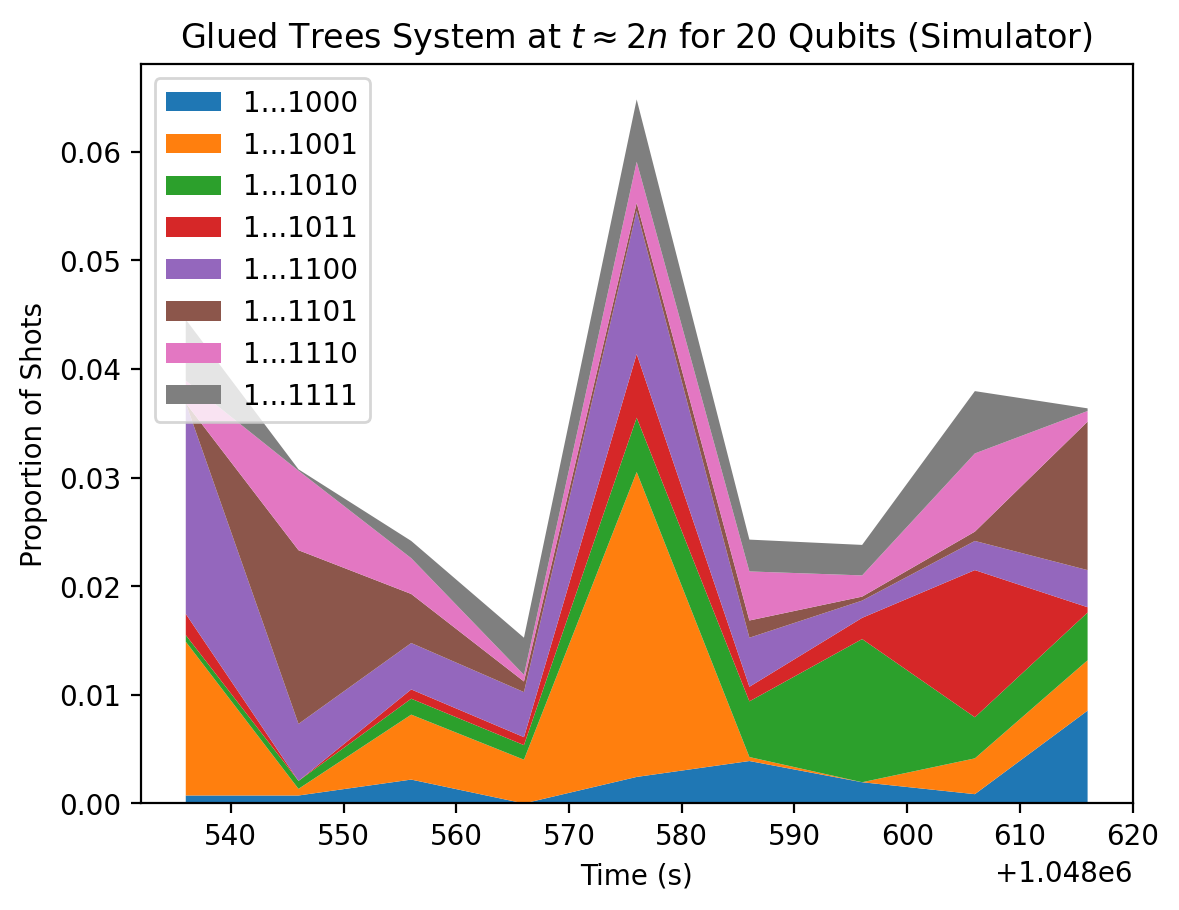

In [37]:
graph_results(20, sim=True)